In [10]:
# import packages
import numpy as np
import scipy.integrate as integrate

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from matplotlib import cm
from matplotlib.ticker import LinearLocator
## set default plot size
plt.rcParams["figure.figsize"] = (10, 7)
## set global font size
plt.rcParams.update({'font.size':14})

import astropy.units as u
from astropy import constants as const

# The Gaia phase-space snail

Following Tremaine et al. (2023), I animate the 1D vertical oscillations of stars in a disk, modeled by a self-gravitating isothermal slab.

Eqs. 4-8 describe the dynamics of the slab, and Eq. 1 describes the time evolution of any density perturbation.

# Slab dynamics

Here, I write down Eqs. 4-8 from Tremaine et al. (2023), which includes the dynamics of the slab and the definitions of our angle-action coordinates.

First, I'll simulate just one star at an arbitrary $(\theta,J)$. Eventually, I'll sample ~10,000-100,000 stars from the distribution function Eq. 6.

## Vertical oscillation

Suppose a perturbation at time $t_i$ changes the distribution function $f$ by amplitude $f_0(J)$. Furthermore, for simplicity, only consider the perturbation's m=1 Fourier component in $\theta$. Then this perturbation evolves as:
$$f_0(J) \cos\left[\theta - \Omega(J)(t-t_i)-\theta_i\right] $$

In [15]:
## Omega definitions
def Omega_big(J, Omega_small=1/np.sqrt(2)):
    '''
    See paragraph after Eq. 8 of Tremaine et al. (2023); orbital frequency
    when the action J >> sigma*z_0. Omega_small is the limit of Omega
    when J << sigma*z_0.
    
    '''
    
    coeff = (Omega_small**2 * np.pi)**2
    coeff = (coeff / 3)**(1/3)
    return coeff * J**(-1/3)

def Omega_big_deriv(J, Omega_small=1/np.sqrt(2)):
    '''
    Derivative of the function Omega_big wrt J.
    
    '''
    
    coeff = (Omega_small**2 * np.pi)**2
    coeff = (coeff / 3)**(1/3)
    
    return coeff * (-1/3) * J**(-4/3)

def Omega_interm(J, Omega_small=1/np.sqrt(2)):
    '''
    The "intermediate" expression for Omega: it's an
    interpolation between the low-J and high-J regimes for Omega
    (represented by Omega_small and Omega_big, respectively).
    
    The interpolated function has form a/(1 + b*J^{1/3}). 
    
    '''
    
    # Omega=Omega_small for J=0
    a = Omega_small 
    # coefficient in Omega_big expression
    Omega_big_coeff = Omega_big(1, Omega_small) 
    # for large J, Omega_big ~ Omega_big_coeff * J^{-1/3} ~ a/b * J^{-1/3}
    b = a / Omega_big_coeff

    return a / (1 + b*(J**(1/3)))
    

def Omega(J):
    '''
    Eq. 8 of Tremaine et al. (2023); orbital frequency. Refer to notes on 
    notation and definitions (e.g., definition of Omega_small, setting
    z_0 = 0).
    
    '''
    
    Omega_small = 1 / np.sqrt(2) # norm'd s.t. sigma*z_0=1
    
    return Omega_interm(J, Omega_small) 

def dOmega_dJ(J, Omega_small=1/np.sqrt(2)):
    '''
    Derivative of Omega(J), assuming that Omega(J) = a/(1 + b*J^{1/3}). I got
    this expression from Wolfram Alpha.
    
    '''
    
    # Omega=Omega_small for J=0
    a = Omega_small 
    # coefficient in Omega_big expression
    Omega_big_coeff = Omega_big(1, Omega_small) 
    # for large J, Omega_big ~ Omega_big_coeff * J^{-1/3} ~ a/b * J^{-1/3}
    b = a / Omega_big_coeff
    
    expr1 = -a * b * J**(-2/3) / 3
    expr2 = (b*J**(1/3) + 1)**2

    return expr1 / expr2

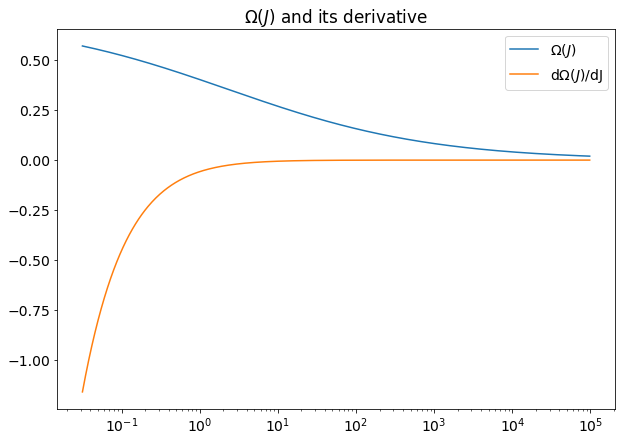

In [26]:
xs = np.arange(-1.5, 5, 1e-2)
xs = 10**xs

plt.plot(xs, Omega(xs), label="$\Omega(J)$")
plt.plot(xs, dOmega_dJ(xs), label="d$\Omega(J)$/dJ")
plt.xscale("log")
plt.title("$\Omega(J)$ and its derivative")

plt.legend()
plt.show()

In [4]:
def delta_f(theta, J, t, A_0=1, t_i=0, theta_i=0):
    '''
    Eq. 1 of Tremaine et al. (2023). Suppose a perturbation
    at time t_i changes the distribution function f
    by amplitude A_0. For simplicity, only consider the 
    m=1 Fourier component in theta. Then, as a function of time,
    this perturbation evolves as:
    
    delta_f(theta,J,t) = A_0 * cos[theta - Omega(J)(t-t_i) - theta_i]
    
    '''
        
    phase = theta - Omega(J)*(t-t_i) - theta_i
    
    return A_0 * np.cos(phase)

## 2D animation

Adapting my code from my "Phase Mixing Plots" notebook.

In [5]:
# time range
tmin = 0
tmax = 100 # in Fig. 3, the time T-t_i goes to 100
tstep = 0.5
ts = np.arange(tmin, tmax, tstep)

# phase space (angle vs. action) grid
theta_min = 0
theta_max = 2*np.pi
J_min = 1e-5
# in Scott's paper, the max. value of (v/sigma)*(z/z_0) ~ 20 in Fig. 3, and 
# we norm'd s.t. sigma*z_0=1. from eq. 7, J is roughly prop to v*z 
J_max = 20 
step = 0.1

thetas = np.arange(theta_min, theta_max, theta_max/50)
Js = np.arange(J_min, J_max, step)
thetas, Js = np.meshgrid(thetas, Js)

In [6]:
# test that delta_f can take in a meshgrid
Z = delta_f(thetas, Js, 0.)

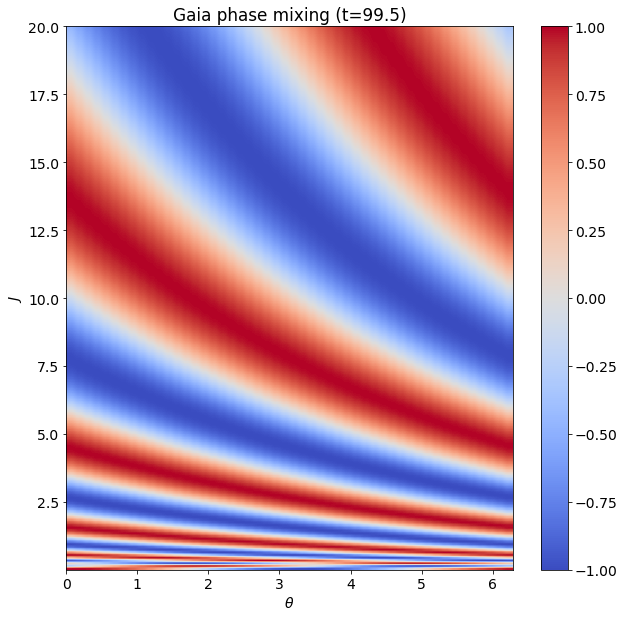

In [7]:
# ## old animation (using artist animation)

# fig, ax = plt.subplots(1,1,figsize=(10,10))

# # ims is a list of lists, each row is a list of artists to draw in the
# # current frame; here we are just animating one artist, the image, in
# # each frame
# ims = []

# # initialize the color bar
# im = ax.imshow(delta_f(thetas, Js, t=0), cmap=cm.coolwarm, animated=True)
# fig.colorbar(im)
# plt.title('Gaia phase mixing')

# # the overdensity at theta=0 as a function of time; ie, delta_n(theta=0, t)
# delta_n_array = []

# # make each frame
# for t in ts:
#     Z = delta_f(thetas, Js, t)
#     delta_n = np.sum(Z[:, 0]) # integrate over J
#     delta_n_array.append(delta_n)
    
#     im = ax.imshow(Z, cmap=cm.coolwarm, origin='lower', \
#                    extent=(theta_min, theta_max, J_min, J_max), animated=True, \
#                    aspect='auto') # automatically set plot's aspect ratio
#     ax.set_title('Gaia phase mixing (t=' + str(t) + ')')
#     plt.xlabel(r'$\theta$')
#     plt.ylabel(r'$J$')
    
#     ims.append([im])


# ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True)

# # To save the animation, use e.g.
# #
# ani.save("Gaia_phase_mixing_temp.mp4")
# #
# # or
# #
# # writer = animation.FFMpegWriter(
# #     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# # ani.save("phase_mixing.mp4", writer=writer)

# # plt.show()

Sources for using FuncAnimation instead of ArtistAnimation:

https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html

https://stackoverflow.com/questions/18274137/how-to-animate-text-in-matplotlib

0
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


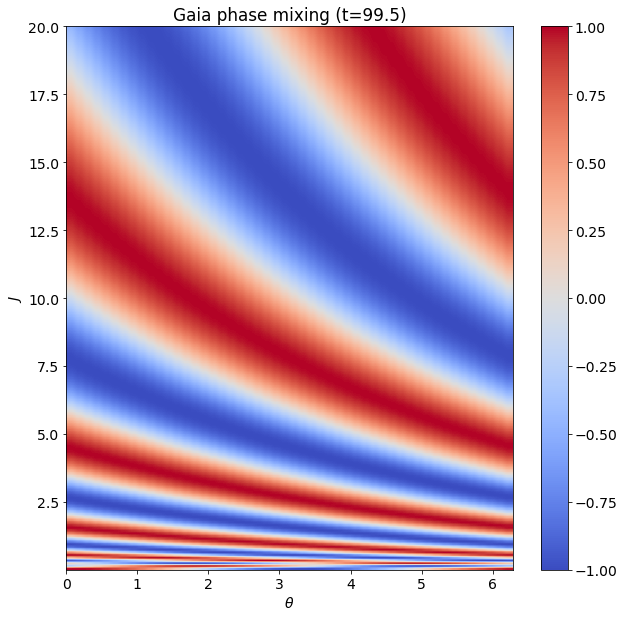

In [8]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

# initialize the color bar
im = ax.imshow(delta_f(thetas, Js, t=0), cmap=cm.coolwarm, animated=True)
fig.colorbar(im)

# the overdensity at theta=0 as a function of time; ie, delta_n(theta=0, t)
delta_n_array = []

def updatefig(num):
    print(num)
    global im
    t = ts[num]
    Z = delta_f(thetas, Js, t)
    delta_n = np.sum(Z[:, 0]) # integrate over J
    delta_n_array.append(delta_n)
    
    ax.set_title('Gaia phase mixing (t=' + str(t) + ')')
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$J$')
    
    im = ax.imshow(Z, cmap=cm.coolwarm, origin='lower', \
                   extent=(theta_min, theta_max, J_min, J_max), animated=True, \
                   aspect='auto') # automatically set plot's aspect ratio
    return im,


ani = animation.FuncAnimation(fig, updatefig, frames=len(ts), interval=100, blit=True)

ani.save("Gaia_phase_mixing_func_anim.mp4")

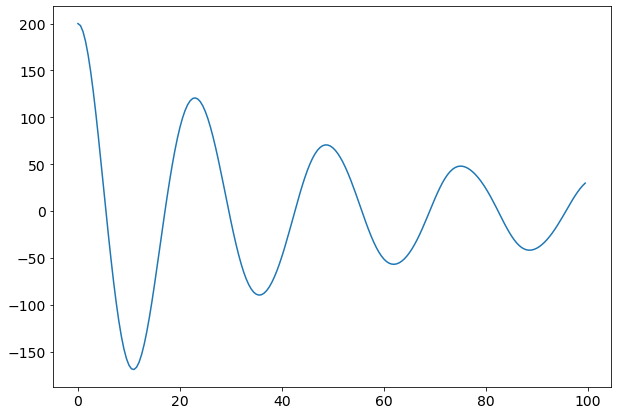

In [9]:
# density at theta=0
plt.plot(ts, delta_n_array[2:])

In [56]:
def Hamiltonian(J):
    '''
    Computes the Hamiltonian of our system by integrating Omega(J)
    from 0 to J. (Underneath Eq. 8 in Scott's paper, it's stated that
    Omega = dH/dJ.) We assume that Omega=0 for H=0.
    
    
    '''
    
    return integrate.quad(Omega, 0, J)[0]

def f_0(J): 
    '''
    Initial distribution function of our system, using Eq. 6 of Scott's
    paper (ignoring the constant coefficient).
    
    '''
    
    return np.exp(-1*Hamiltonian(J))

def df0_dJ(J):
    '''
    The derivative of our initial distribution function, f_0(J) ~ exp(-H(J)). 
    We have df_0/dJ = -dH/dJ * exp(-H) = -Omega(J) * exp(-H).
    
    '''
    
    return -Omega(J) * np.exp(-1*Hamiltonian(J))

def f0_second_deriv(J):
    '''
    The derivative of our initial distribution function, f_0(J) ~ exp(-H(J)). 
    By product rule, taking the derivative of df_0/dJ yields:
    
    -dOmega/dJ * exp(-H) + -Omega * [-dH/dJ * exp(-H)] = -dOmega/dJ * exp(-H) + (Omega^2)*exp(-H)
    = (-dOmega/dJ + Omega^2) * exp(-H)
    
    '''
        
    coeff = Omega(J)**2 - dOmega_dJ(J)
    
    return coeff * np.exp(-1*Hamiltonian(J))

In [59]:
def delta_f_2nd_order(theta, J, t):
    '''
    Represents the closed form of the second-order solution for delta_f 
    given two hammers. See the last equations in Section 7.3 in my senior thesis 
    notes.
    
    
    '''
    
    n1, n2 = 1, 2
    t1, t2 = 5, 15
    t_echo = (n2*t2 - n1*t1) / (n2 - n1)
    
    # amplitudes of hammers; for now, assume they're independent of J
    # could use SymPy or something similar to evaluate the d/dJ derivatives
    A1, A2 = 0.1, 0.2
    
    # function that contains the time evolution
    psi = (n2 - n1) * (theta - Omega(J)*(t - t_echo))
    
    # form of delta_f^(2) that assumes constant A_1, A_2
    
    expr1 = 2*A1*A2 * np.cos(psi) * n1*n2* f0_second_deriv(J)
    expr2 = 2*A1*A2 * np.sin(psi) * n1**2 * n2 * (t2-t1) * dOmega_dJ(J) * df0_dJ(J)
    
    return expr1 - expr2

In [61]:
delta_f_2nd_order(1,0.1,0)

-0.17665775699791988